In [465]:
from openni import openni2
from openni import _openni2 as c_api
import numpy as np
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud as pc
import time
import pandas as pd

%matplotlib inline

Various setup variables

In [466]:
Depth_ResX = 512
Depth_ResY = 424
Depth_fps = 30
RGB_ResX = 512
RGB_ResY = 424
RGB_fps = 30

In [467]:
cx = 0.032
cy = 0.033
fx = 5.12
fy = 4.24

Initialize OpenNNI

In [468]:
openni2.initialize("/usr/lib")

Open a device, and get some info from it.

In [469]:
dev = openni2.Device.open_any()
print(dev.get_device_info())

OniDeviceInfo(uri = b'freenect2://0?serial=124535140947', vendor = b'Microsoft', name = b'Kinect', usbVendorId = 45616, usbProductId = 323)


Create a depth stream

In [470]:
dev.set_image_registration_mode(True)
#dev.get_image_registration_mode()
#dev.depth_color_sync = True
#dev.get_image_registration_mode()
dev.set_depth_color_sync_enabled(True)

In [471]:
depth_stream = dev.create_depth_stream()
depth_stream.set_video_mode(c_api.OniVideoMode(pixelFormat=c_api.OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM,
                                               resolutionX=Depth_ResX,
                                               resolutionY=Depth_ResY,
                                               fps=Depth_fps,
                                              ))
depth_sensor_info = depth_stream.get_sensor_info()

Get depth stream video modes

In [472]:
for itm in depth_sensor_info.videoModes:
    print(itm)
max_depth = depth_stream.get_max_pixel_value()
#min_depth = depth_stream.get_min_pixel_value()
min_depth = 0
print("Min depth value: {}".format(min_depth))
print("Max depth value: {}".format(max_depth))

OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM, resolutionX = 512, resolutionY = 424, fps = 30)
OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM, resolutionX = 640, resolutionY = 480, fps = 30)
Min depth value: 0
Max depth value: 10000


Create color stream

In [473]:
rgb_stream = dev.create_color_stream()
rgb_sensor_info = rgb_stream.get_sensor_info()
for itm in rgb_sensor_info.videoModes:
    print(itm)

rgb_stream.set_video_mode(c_api.OniVideoMode(pixelFormat=c_api.OniPixelFormat.ONI_PIXEL_FORMAT_RGB888,
                                             resolutionX=RGB_ResX,
                                             resolutionY=RGB_ResY,
                                             fps=RGB_fps,
                                            ))

OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_RGB888, resolutionX = 512, resolutionY = 424, fps = 30)
OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_RGB888, resolutionX = 1920, resolutionY = 1080, fps = 30)


Start both streams, and get a buffer with data

In [474]:
depth_stream.start()
rgb_stream.start()

depth_frame = depth_stream.read_frame()
depth_data = depth_frame.get_buffer_as_uint16()
rgb_frame = rgb_stream.read_frame()
rgb_data = rgb_frame.get_buffer_as_triplet()

depth_stream.stop()
rgb_stream.stop()

In [475]:
depth_array = np.frombuffer(depth_data, dtype=np.uint16)
print(depth_array.shape)
depth_image = depth_array.reshape(Depth_ResY, Depth_ResX)
print(depth_image.shape)

(217088,)
(424, 512)


In [476]:
depth_image[depth_image==0x0000] = 0 #max_depth
depth_image[depth_image==0x7ff8] = 0
depth_image[depth_image==0xfff8] = 0
max_depth = np.max(depth_image)
#depth_image = (depth_image - min_depth) / (max_depth - min_depth)
print(np.min(depth_image))
print(np.max(depth_image))

0
4425


In [477]:
df = pd.DataFrame(depth_image.reshape(-1, ))
df.describe()

,0
count,217088.000000
mean,595.758066
std,1026.674571
min,0.000000
25%,0.000000
50%,0.000000
75%,1332.000000
max,4425.000000


In [478]:
color_array = np.frombuffer(rgb_data, dtype=np.uint8)
print(color_array.shape)
color_image = color_array.reshape(RGB_ResY, RGB_ResX, -1)
#color_image = color_array.reshape(Depth_ResY, Depth_ResX, -1)
#color_image = color_array.reshape(480, 640, -1)
print(color_image.shape)

(651264,)
(424, 512, 3)


In [479]:
#color_image[depth_image==0] = (0, 0, 0)

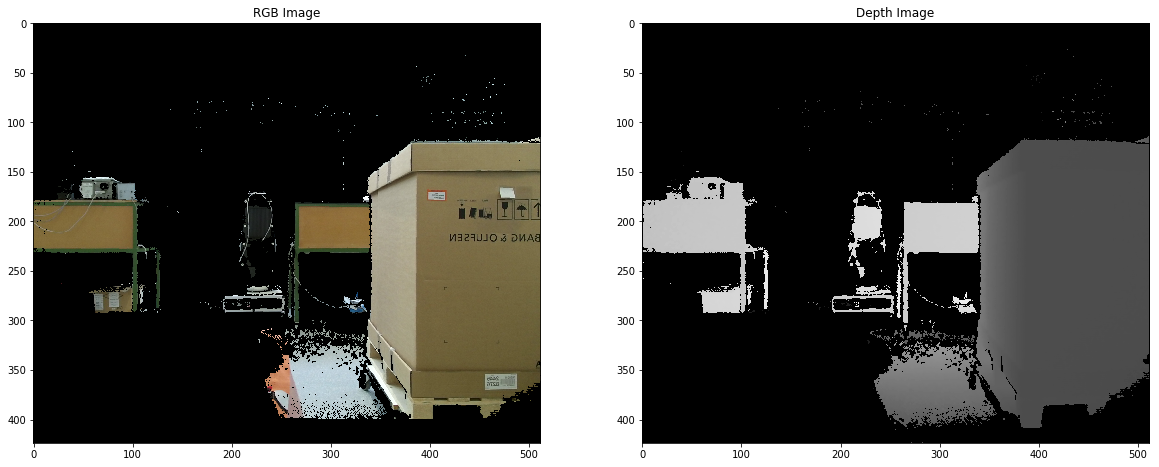

In [480]:
fig, subs = plt.subplots(1, 2, figsize=(20, 8))
subs[0].set_title("RGB Image")
subs[0].imshow(color_image)
subs[1].set_title("Depth Image")
subs[1].imshow(depth_image, cmap='gray')

In [481]:
"""
before = time.time()
num_points = Depth_ResX * Depth_ResY

point_cloud = np.zeros((num_points, 6))
#point_cloud = np.zeros((num_points, 3))
print(point_cloud[0,:])

counter = 0
for x in range(Depth_ResX):
    for y in range(Depth_ResY):
        # Skip invalid points
        if depth_image[y, x] != 0.0:
            point_cloud[counter, 0] = y
            point_cloud[counter, 1] = x
            point_cloud[counter, 2] = -depth_image[y, x] * 255.0 * 1
            #point_cloud[counter, 2] = -np.log(raw_depth_1_channel[x, y]) * 255.0
            #point_cloud[counter, 2] = np.tan(raw_depth_1_channel[x, y]+0.5)
            if depth_image[y, x] != 0:
                point_cloud[counter, 3] = color_image[y, x, 0]
                point_cloud[counter, 4] = color_image[y, x, 1]
                point_cloud[counter, 5] = color_image[y, x, 2]
            else:
                #point_cloud[counter, 2] = 0
                point_cloud[counter, 3] = 0
                point_cloud[counter, 4] = 0
                point_cloud[counter, 5] = 0
            counter += 1
after = time.time()
print("Execution time: {}".format(after-before))
print("Points set: {}".format(counter))
"""

'\nbefore = time.time()\nnum_points = Depth_ResX * Depth_ResY\n\npoint_cloud = np.zeros((num_points, 6))\n#point_cloud = np.zeros((num_points, 3))\nprint(point_cloud[0,:])\n\ncounter = 0\nfor x in range(Depth_ResX):\n    for y in range(Depth_ResY):\n        # Skip invalid points\n        if depth_image[y, x] != 0.0:\n            point_cloud[counter, 0] = y\n            point_cloud[counter, 1] = x\n            point_cloud[counter, 2] = -depth_image[y, x] * 255.0 * 1\n            #point_cloud[counter, 2] = -np.log(raw_depth_1_channel[x, y]) * 255.0\n            #point_cloud[counter, 2] = np.tan(raw_depth_1_channel[x, y]+0.5)\n            if depth_image[y, x] != 0:\n                point_cloud[counter, 3] = color_image[y, x, 0]\n                point_cloud[counter, 4] = color_image[y, x, 1]\n                point_cloud[counter, 5] = color_image[y, x, 2]\n            else:\n                #point_cloud[counter, 2] = 0\n                point_cloud[counter, 3] = 0\n                point_clou

In [482]:
"""
before = time.time()

pc2 = np.zeros((num_points, 6))
pc2[:,0] = np.tile(np.arange(0, Depth_ResY), Depth_ResX)
pc2[:,1] = np.tile(np.arange(0, Depth_ResX), Depth_ResY)
pc2[:,3] = depth_image.ravel() * 255.0
pc2[:,3:] = (0, 0, 0)

after = time.time()
print("Execution time: {}".format(after-before))
"""

'\nbefore = time.time()\n\npc2 = np.zeros((num_points, 6))\npc2[:,0] = np.tile(np.arange(0, Depth_ResY), Depth_ResX)\npc2[:,1] = np.tile(np.arange(0, Depth_ResX), Depth_ResY)\npc2[:,3] = depth_image.ravel() * 255.0\npc2[:,3:] = (0, 0, 0)\n\nafter = time.time()\nprint("Execution time: {}".format(after-before))\n'

In [483]:
index_x = np.tile(np.arange(0, Depth_ResX), (Depth_ResY, 1))
index_y = np.tile(np.arange(0, Depth_ResY), (Depth_ResX, 1)).T
print(index_x.shape)
print(index_y.shape)

(424, 512)
(424, 512)


https://codereview.stackexchange.com/questions/79032/generating-a-3d-point-cloud?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

In [572]:
before = time.time()

valid_points = np.count_nonzero(depth_image != 0.0)
valid_rgb = color_image[depth_image != 0.0]

#valid_depth = -depth_image[depth_image != 0.0] / 1000
#valid_x = 6 - 2 * (index_x[depth_image != 0.0] - 639 / 2) * np.tan(np.deg2rad(57) / 2) * valid_depth / 640
#valid_y = 4.5 - 2 * (479 - index_y[depth_image != 0.0] - 497 / 2) * np.tan(np.deg2rad(43) / 2) * valid_depth / 480

valid_depth = depth_image[depth_image != 0.0]
#valid_x = (index_x[depth_image != 0.0] - cx) * valid_depth / 256.0 / fx
#valid_y = (index_y[depth_image != 0.0] - cy) * valid_depth / 256.0 / fy
valid_x = index_x[depth_image != 0.0] / (valid_depth / 256.0) / fx
valid_y = index_y[depth_image != 0.0] / (valid_depth / 256.0) / fy

pc2 = np.zeros((valid_points, 6))
pc2[:,0] = valid_x * 2
pc2[:,1] = valid_y * 2
pc2[:,2] = valid_depth / 256.0 * 2
pc2[:,3:] = valid_rgb

after = time.time()
print("Execution time: {}".format(after-before))

Execution time: 0.014111995697021484


In [485]:
"""
before = time.time()

#depth = depth_image[..., 0]
valid = (depth_image > 0) & (depth_image < 255)

rows, cols = depth_image.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
z = np.where(valid, depth_image, np.nan)
x = np.where(valid, z * (c - cx) / fx, 0)
y = np.where(valid, z * (r - cy) / fy, 0)

pc3 = np.dstack((x, y, z))

after = time.time()
print("Execution time: {}".format(after-before))

"""

'\nbefore = time.time()\n\n#depth = depth_image[..., 0]\nvalid = (depth_image > 0) & (depth_image < 255)\n\nrows, cols = depth_image.shape\nc, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)\nz = np.where(valid, depth_image, np.nan)\nx = np.where(valid, z * (c - cx) / fx, 0)\ny = np.where(valid, z * (r - cy) / fy, 0)\n\npc3 = np.dstack((x, y, z))\n\nafter = time.time()\nprint("Execution time: {}".format(after-before))\n\n'

In [486]:
np.tile(np.arange(0, 2), 3)

array([0, 1, 0, 1, 0, 1])

In [561]:
points = pd.DataFrame(point_cloud, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
points.describe()

,x,y,z,red,green,blue
count,217088.000000,217088.000000,217088.000000,217088.000000,217088.000000,217088.000000
mean,59.980561,79.970906,-33.449747,40.336113,42.385848,41.191047
std,109.024689,160.138765,66.137622,71.399475,74.900508,72.961904
min,0.000000,0.000000,-255.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,401.000000,510.000000,0.000000,255.000000,255.000000,255.000000


In [573]:
points2 = pd.DataFrame(pc2, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
points2.describe()

,x,y,z,red,green,blue
count,66277.000000,66277.000000,66277.000000,66277.000000,66277.000000,66277.000000
mean,23.180463,18.756482,15.245193,125.886914,118.142448,89.546027
std,12.232078,8.635576,7.019026,44.045209,45.176608,52.327474
min,0.024137,0.000000,3.906250,0.000000,0.000000,0.000000
25%,12.658228,11.366220,10.429688,109.000000,97.000000,57.000000
50%,28.773234,18.739250,10.500000,125.000000,109.000000,69.000000
75%,33.457526,25.450546,17.359375,153.000000,148.000000,131.000000
max,81.906300,88.234635,34.570312,254.000000,255.000000,255.000000


In [574]:
cloud = pc(points2)
cloud.plot(IFrame_shape=(1200, 700))